In [11]:
import cv2
import os
import numpy as np
import dlib
from imutils import face_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import csv



# créer deux listes contenant des vidéos de baillement et des vidéos normales.


In [16]:


# Path to folders containing yawning and normal videos
yawning_folder = 'C:\\Users\\MSI\OneDrive\\Bureau\\newYAWDD\\VID_Yawning'
normal_folder = 'C:\\Users\\MSI\\OneDrive\\Bureau\\newYAWDD\\VID_Normale'

# Lists to store paths of yawning and normal videos
yawning_videos = []
normal_videos = []

# Read video files in the yawning folder
for file in os.listdir(yawning_folder):
    if "Yawning" in file:  # Check if "Yawning" is present in the filename
        video_path = os.path.join(yawning_folder, file)
        yawning_videos.append(video_path)

# Read video files in the normal folder
for file in os.listdir(normal_folder):
    if "Normal" in file:  # Check if "Normal" is present in the filename
        video_path = os.path.join(normal_folder, file)
        normal_videos.append(video_path)



# script Python pour convertir les vidéos en ensembles de frames et les stocker dans le dossier extracted_frames11

In [13]:


# Function to extract frames from a video and save as images
def extract_frames(video_path, output_folder):
    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Open the video file
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    # Read until video is completed
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        # Save frame as image in the output folder
        frame_output_path = os.path.join(output_folder, f"frame_{frame_count}.jpg")
        cv2.imwrite(frame_output_path, frame)
        frame_count += 1
    # Release the video capture object
    cap.release()

# Path to the folder where the extracted frames will be saved
output_frames_folder = 'C:\\Users\\MSI\\OneDrive\\Bureau\\newYAWDD\\extracted_frames11'

# Process yawning videos
for video_path in yawning_videos:
    video_name = os.path.splitext(os.path.basename(video_path))[0]
    output_folder = os.path.join(output_frames_folder, f"{video_name}_frames")
    extract_frames(video_path, output_folder)

# Process normal videos
for video_path in normal_videos:
    video_name = os.path.splitext(os.path.basename(video_path))[0]
    output_folder = os.path.join(output_frames_folder, f"{video_name}_frames")
    extract_frames(video_path, output_folder)


# Script pour détecter les images représentant un bâillement et les placer dans un dossier spécifique, et les images normales dans un autre dossier. La détection sera effectuée à l'aide de la bibliothèque Delib."

En bref, Delib est une bibliothèque qui fournit des fonctionnalités de détection d'objets et d'analyse d'images, souvent utilisée pour des tâches telles que la reconnaissance d'objets, la détection de visages, ou dans ce cas, la détection de bâillements dans des 

In [14]:



# Initialize dlib's face detector and shape predictor
p = "shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(p)

# Path to the root folder containing the subfolders with extracted frames
root_folder_path = r'C:\Users\MSI\OneDrive\Bureau\newYAWDD\extracted_frames11'

# Output folder to store yawning and normal face images
output_folder_path = r'C:\Users\MSI\OneDrive\Bureau\newYAWDD\detection'
if not os.path.exists(output_folder_path):
    os.makedirs(output_folder_path)

def mouth_aspect_ratio(mouth):
    A = np.linalg.norm(mouth[2] - mouth[9])
    B = np.linalg.norm(mouth[4] - mouth[7])
    C = np.linalg.norm(mouth[0] - mouth[6])
    mar = (A + B) / (2.0 * C)
    return mar

def detect_yawn(img_path):
    image = cv2.imread(img_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 0)
    for rect in rects:
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)
        mouth = shape[48:68]
        mar = mouth_aspect_ratio(mouth)
        if mar > 0.6:
            return True
    return False

# Process each subfolder containing frames
for subdir, dirs, files in os.walk(root_folder_path):
    for img_name in files:
        img_path = os.path.join(subdir, img_name)
        if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            if detect_yawn(img_path):
                output_image_path = os.path.join(output_folder_path, "yawning", img_name)
                os.makedirs(os.path.dirname(output_image_path), exist_ok=True)
                cv2.imwrite(output_image_path, cv2.imread(img_path))
            else:
                output_image_path = os.path.join(output_folder_path, "normal", img_name)
                os.makedirs(os.path.dirname(output_image_path), exist_ok=True)
                cv2.imwrite(output_image_path, cv2.imread(img_path))

print("Detection process is completed.")


Detection process is completed.


# Le script parcourt toutes les images (yawn et no yawn), détecte les visages, calcule le rapport d'aspect des yeux (eye aspect ratio), le rapport d'aspect de la bouche (mouth aspect ratio) et (la distance entre les sourcils), puis crée un jeu de données nommé 'output_features2.csv'. Ce jeu de données contient ces caractéristiques avec des étiquettes pour entraîner notre modèle 

In [15]:


# Chemins vers les dossiers
yawning_folder_path = r"C:\Users\MSI\OneDrive\Bureau\newYAWDD\detection\yawning"
no_yawning_folder_path = r"C:\Users\MSI\OneDrive\Bureau\newYAWDD\detection\normal"
output_csv_path = "output_features2.csv"

# Initialisation de Dlib's face detector (HOG) et puis création du facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# Fonction pour calculer l'Eye Aspect Ratio (EAR)
def eye_aspect_ratio(eye):
    A = np.linalg.norm(eye[1] - eye[5])
    B = np.linalg.norm(eye[2] - eye[4])
    C = np.linalg.norm(eye[0] - eye[3])
    ear = (A + B) / (2 * C)
    return ear

# Fonction pour calculer le Mouth Aspect Ratio (MAR)
def mouth_aspect_ratio(mouth):
    A = np.linalg.norm(mouth[13] - mouth[19])  # 49 - 55
    B = np.linalg.norm(mouth[14] - mouth[18])  # 50 - 54
    C = np.linalg.norm(mouth[12] - mouth[16])  # 48 - 52
    mar = (A + B) / (2 * C)
    return mar

# Fonction pour calculer la distance sourcil-oeil
def brow_eye_distance(brow, eye):
    brow_middle = np.mean(brow, axis=0)
    eye_top = np.min(eye, axis=0)
    distance = np.linalg.norm(brow_middle - eye_top)
    return distance

# Fonction pour traiter les images et écrire les données dans un fichier CSV
def process_images(writer, folder_path, yawning_label):
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    for img_name in image_files:
        img_path = os.path.join(folder_path, img_name)
        image = cv2.imread(img_path)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        rects = detector(gray, 0)

        # Utiliser une variable 'face_detected' pour indiquer si un visage est détecté ou non
        face_detected = False

        for rect in rects:
            face_detected = True  # Un visage est détecté
            shape = predictor(gray, rect)
            shape = face_utils.shape_to_np(shape)

            leftEye = shape[42:48]
            rightEye = shape[36:42]
            leftBrow = shape[22:27]
            rightBrow = shape[17:22]
            mouth = shape[48:68]

            ear_left = eye_aspect_ratio(leftEye)
            ear_right = eye_aspect_ratio(rightEye)
            ear = (ear_left + ear_right) / 2.0

            mar = mouth_aspect_ratio(mouth)
            
            brow_eye_dist_left = brow_eye_distance(leftBrow, leftEye)
            brow_eye_dist_right = brow_eye_distance(rightBrow, rightEye)
            brow_eye_distance_avg = (brow_eye_dist_left + brow_eye_dist_right) / 2.0

            writer.writerow([img_name, ear, mar, brow_eye_distance_avg, yawning_label])

        if not face_detected:
            # Si aucun visage n'est détecté, écrire 'N/A' pour les caractéristiques
            writer.writerow([img_name, "N/A", "N/A", "N/A", yawning_label])

# Écriture des en-têtes et traitement des images
with open(output_csv_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    # Changer les noms des colonnes dans le fichier CSV
    writer.writerow(['Nom de l\'image', 'Eye Aspect Ratio ', 'Mouth Aspect Ratio ', 'Distance Sourcil-Oeil', 'Étiquette (Bâillement)'])

    # Images avec bâillement
    process_images(writer, yawning_folder_path, 1)

    # Images sans bâillement
    process_images(writer, no_yawning_folder_path, 0)

print("Le processus de création du fichier CSV est terminé.")


Le processus de création du fichier CSV est terminé.


# Construction de modèle et prétraitement des données

In [34]:

import pandas as pd

# Spécifiez le nouveau chemin complet du fichier CSV et l'encodage approprié
file_path = 'C:/Users/MSI/OneDrive/Bureau/newYAWDD/output_features2.csv'
encoding = 'ISO-8859-1'  

# Lecture du fichier CSV dans un DataFrame avec l'encodage spécifié
df = pd.read_csv(file_path, encoding=encoding)

# Afficher les  5 premières lignes du DataFrame pour vérifier s'il a été correctement chargé
df.head()




,Nom de l'image,Eye Aspect Ratio,Mouth Aspect Ratio,Distance Sourcil-Oeil,Étiquette (Bâillement)
0,frame_100.jpg,0.359268,0.353553,24.287603,1
1,frame_101.jpg,0.354358,0.381383,23.658760,1
2,frame_102.jpg,0.358935,0.379896,23.582188,1
3,frame_103.jpg,0.344837,0.432921,24.140373,1
4,frame_104.jpg,0.366128,0.401998,24.130492,1


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 959 entries, 0 to 958
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Nom de l'image          959 non-null    object 
 1   Eye Aspect Ratio        950 non-null    float64
 2   Mouth Aspect Ratio      950 non-null    float64
 3   Distance Sourcil-Oeil   950 non-null    float64
 4   Étiquette (Bâillement)  959 non-null    int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 37.6+ KB


# effectuer un sous-échantillonnage (undersampling) des données de la classe majoritaire (label 0) afin de les équilibrer avec la classe minoritaire (label 1) et mélanger alétoirement les lignes 


In [36]:

# Display the count of values for each label
print(df['Étiquette (Bâillement)'].value_counts())

# Separate data based on labels
label_0 = df[df['Étiquette (Bâillement)'] == 0]
label_1 = df[df['Étiquette (Bâillement)'] == 1]

# Undersample label 0 to match the number of samples in label 1
sampled_label_0 = label_0.sample(n=len(label_1), random_state=42)

# Concatenate the undersampled label 0 and label 1 data
df_balanced = pd.concat([sampled_label_0, label_1])

# Shuffle the rows to mix the data
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Display the new count of values for each label to verify balance
print(df_balanced['Étiquette (Bâillement)'].value_counts())


# Mélanger aléatoirement les lignes du DataFrame
# new_df = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)


0    738
1    221
Name: Étiquette (Bâillement), dtype: int64
1    221
0    221
Name: Étiquette (Bâillement), dtype: int64


In [37]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Nom de l'image          442 non-null    object 
 1   Eye Aspect Ratio        439 non-null    float64
 2   Mouth Aspect Ratio      439 non-null    float64
 3   Distance Sourcil-Oeil   439 non-null    float64
 4   Étiquette (Bâillement)  442 non-null    int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 17.4+ KB


# trouver les meilleurs parameteres a laide de la méthode gridsearch 

In [51]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Définition des paramètres à tester
param_grid = {
    'n_estimators': [20,30,50, 100],  # Nombre d'arbres dans la forêt
    'max_depth': [None, 5, 10, 20],  # Profondeur maximale de chaque arbre
    'min_samples_split': [2, 5, 10],  # Nombre minimum d'échantillons requis pour diviser un nœud
}

# Création du modèle RandomForestClassifier
rf = RandomForestClassifier()

# Recherche par grille pour trouver les meilleurs paramètres
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Affichage des meilleurs paramètres trouvés
best_params = grid_search.best_params_
print("Meilleurs paramètres :", best_params)


Meilleurs paramètres : {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 30}


# split data - fit le modele - predections - evaluation

In [52]:


# Séparation des données en X et y
X = new_df.drop(['Étiquette (Bâillement)', 'Nom de l\'image'], axis=1)
y = new_df['Étiquette (Bâillement)']

# Remplissage des valeurs manquantes (optionnel)
X.fillna(X.mean(), inplace=True)

# Split des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Création du modèle Random Forest avec des paramètres spécifiés
model = RandomForestClassifier(max_depth=10, min_samples_split=2, n_estimators=30)

# Entraînement du modèle
model.fit(X_train, y_train)

# Prédictions avec l'ensemble de test
predictions = model.predict(X_test)

# Évaluation du modèle
accuracy = accuracy_score(y_test, predictions)
print(f"Précision du modèle : {accuracy * 100:.2f}%\n")



Précision du modèle : 91.01%



# Création d'un barplot pour représenter les valeurs de TP (Vrais Positifs), TN (Vrais Négatifs), FP (Faux Positifs) et FN (Faux Négatifs)

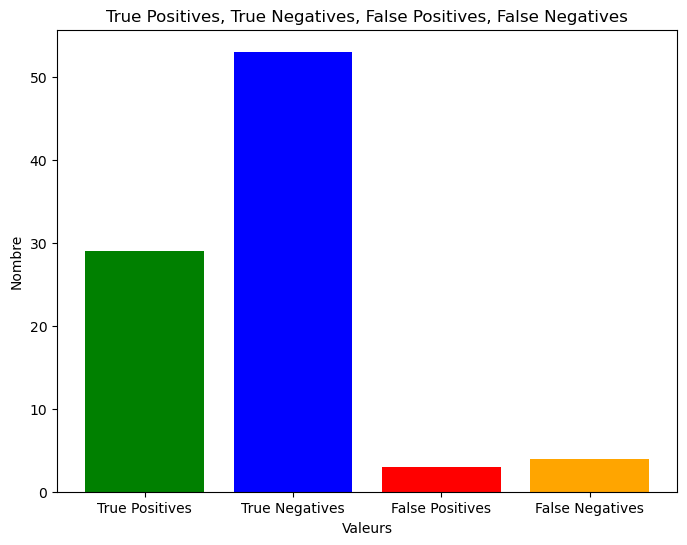

In [53]:
# Extraction des valeurs TP, TN, FP, FN de la matrice de confusion
tp = conf_matrix[1, 1]
tn = conf_matrix[0, 0]
fp = conf_matrix[0, 1]
fn = conf_matrix[1, 0]


values = [tp, tn, fp, fn]
labels = ['True Positives', 'True Negatives', 'False Positives', 'False Negatives']

plt.figure(figsize=(8, 6))
plt.bar(labels, values, color=['green', 'blue', 'red', 'orange'])
plt.xlabel('Valeurs')
plt.ylabel('Nombre')
plt.title('True Positives, True Negatives, False Positives, False Negatives')
plt.show()

